In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font',family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus']=False

In [2]:
#데이터 읽어오기
df=pd.read_csv('PV_Weather_Inchon_2020 (1).csv')

In [3]:
# 일시를 datetime형으로 변환
df.index = pd.to_datetime(df['Datetime'])
# 기존 컬럼 삭제
df = df.drop(['Datetime'], axis=1)
df

,Tem,Irr,PV
Datetime,,,
2020-01-01 00:00:00,-5.4,0.0,0.0
2020-01-01 01:00:00,-5.2,0.0,0.0
2020-01-01 02:00:00,-5.3,0.0,0.0
2020-01-01 03:00:00,-5.4,0.0,0.0
2020-01-01 04:00:00,-5.3,0.0,0.0
...,...,...,...
2020-12-31 19:00:00,-6.9,0.0,0.0
2020-12-31 20:00:00,-7.2,0.0,0.0
2020-12-31 21:00:00,-6.8,0.0,0.0


In [4]:
#학습용
train_set = df.loc['2020-01-01 00:00:00':'2020-09-30 23:00:00']
#테스트용
test_set = df.loc['2020-10-01 00:00:00 ': '2020-10-31 23:00:00']

In [5]:
#평균, 표준편차
train_stats = train_set.describe().transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Tem,6576.0,14.559307,9.339420,-10.5,6.5,16.500,22.700,33.900
Irr,6576.0,0.641384,0.935517,0.0,0.0,0.050,1.080,3.570
PV,6576.0,30.141800,46.578316,0.0,0.0,0.072,48.476,182.284


In [6]:
#정규화 z변환
def norm(x):
  return (x-train_stats['mean'])/train_stats['std']

#학습용 데이터 정규화
normed_train_data = norm(train_set)
#테스트용 데이터 정규화
normed_test_data = norm(test_set)

In [7]:
#학습용 데이터 값 추출
normed_train_data = normed_train_data.values
# 테스트용 데이터 값 추출
normed_test_data = normed_test_data.values

In [8]:
#시간 지연을 갖는 입출력 데이터 만들기
def build_dataset(ts):
  dataX = []
  dataY = []
  for i in range(0, len(ts)-1):
    _x = ts[i,:]
    _y = ts[i+1,-1]
    dataX.append(_x)
    dataY.append(_y)
  return np.array(dataX), np.array(dataY)
#x에서는 현재 시간에 따른 값을 가져오기
#Y에서는 현재 시간에 따른 다음 시간의 값을 가져오기
#

#학습용
normed_trainX, normed_trainY = build_dataset(normed_train_data)
#테스트용
normed_testX, normed_testY = build_dataset(normed_test_data)


모델 설계

In [9]:
#DNN 모델 설계
def build_model():
  #모델 구조
  model = keras.Sequential([
                            keras.layers.Dense(128, activation=tf.nn.relu, input_shape=[3]),#입력층
                            keras.layers.Dense(64,activation=tf.nn.relu), #은닉층 1
                            keras.layers.Dense(32, activation=tf.nn.relu), #은닉층 2
                            keras.layers.Dense(1) #출력층
  ])

  #모델 최적화
  optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

  #모델 컴파일
  model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mean_absolute_error','mean_squared_error'])
  return model

model= build_model()
model.summary()  

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               512       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 10,881
Trainable params: 10,881
Non-trainable params: 0
_________________________________________________________________


In [10]:
#모델 학습
history = model.fit(normed_trainX, normed_trainY, epochs=100)

Epoch 1/100
206/206 [==============================] - 2s 4ms/step - loss: 0.7142 - mean_absolute_error: 0.6825 - mean_squared_error: 0.7142
Epoch 2/100
206/206 [==============================] - 1s 3ms/step - loss: 0.3867 - mean_absolute_error: 0.5065 - mean_squared_error: 0.3867
Epoch 3/100
206/206 [==============================] - 1s 3ms/step - loss: 0.2173 - mean_absolute_error: 0.3675 - mean_squared_error: 0.2173
Epoch 4/100
206/206 [==============================] - 1s 3ms/step - loss: 0.1746 - mean_absolute_error: 0.3006 - mean_squared_error: 0.1746
Epoch 5/100
206/206 [==============================] - 1s 3ms/step - loss: 0.1651 - mean_absolute_error: 0.2749 - mean_squared_error: 0.1651
Epoch 6/100
206/206 [==============================] - 1s 4ms/step - loss: 0.1611 - mean_absolute_error: 0.2635 - mean_squared_error: 0.1611
Epoch 7/100
206/206 [==============================] - 1s 3ms/step - loss: 0.1583 - mean_absolute_error: 0.2573 - mean_squared_error: 0.1583
Epoch 8/100
2

In [11]:
#학습 과정 결과 
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mean_absolute_error,mean_squared_error,epoch
0,0.714209,0.682521,0.714209,0
1,0.386726,0.506488,0.386726,1
2,0.217258,0.367458,0.217258,2
3,0.174587,0.300605,0.174587,3
4,0.165148,0.274898,0.165148,4
...,...,...,...,...
95,0.142328,0.226755,0.142328,95
96,0.142323,0.226838,0.142323,96
97,0.142288,0.227180,0.142288,97
98,0.142285,0.226404,0.142285,98


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


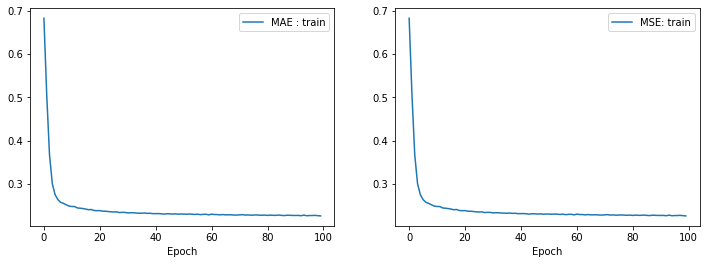

In [12]:
#시각화
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist['epoch'],hist['mean_absolute_error'],label="MAE : train")
plt.xlabel('Epoch')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist['epoch'],hist['mean_absolute_error'], label='MSE: train')
plt.xlabel('Epoch')
plt.legend()

In [13]:
#예측 수행
normed_test_predictions = model.predict(normed_testX).flatten()
normed_test_predictions

array([-0.6195674 , -0.61871004, -0.6195674 , -0.6157963 , -0.6147481 ,
       -0.61177015, -0.6127436 , -0.61116886, -0.52281046, -0.05307928,
        0.27446097,  0.4736052 ,  0.7129773 ,  0.6971774 ,  1.503395  ,
        1.3582063 ,  0.87741244,  0.25027636, -0.32541537, -0.6204853 ,
       -0.6207888 , -0.62098026, -0.62098026, -0.62098026, -0.6195674 ,
       -0.6193098 , -0.61871004, -0.61781347, -0.61781347, -0.61871004,
       -0.6157963 , -0.60801625, -0.24714293,  0.14459002,  0.7446414 ,
        1.202816  ,  0.29405344, -0.33809647, -0.4062576 , -0.24557552,
       -0.2876268 , -0.3016239 , -0.52574   , -0.6159061 , -0.6162102 ,
       -0.6162102 , -0.6162102 , -0.6162102 , -0.6159164 , -0.6164975 ,
       -0.6190921 , -0.6204853 , -0.6207888 , -0.62136304, -0.6202307 ,
       -0.6158334 , -0.46580732, -0.3048737 , -0.08113742,  0.4530467 ,
        1.6607783 ,  1.1015993 ,  0.6490787 ,  0.38123637,  0.5497738 ,
       -0.02244198, -0.48981363, -0.6164975 , -0.6197902 , -0.61

In [14]:
def denorm(y):
  return y*train_stats['std'][2] +train_stats['mean'][2]

testY = denorm(normed_testY)
testY_predictions = denorm(normed_test_predictions)
  

No handles with labels found to put in legend.


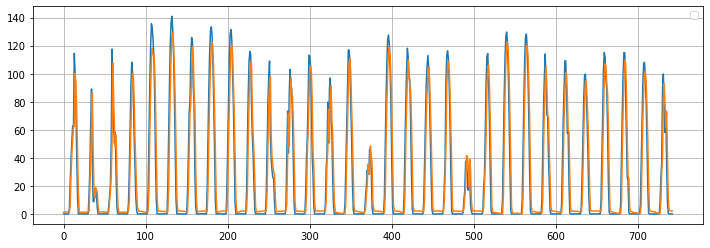

In [15]:
#출력 비교
plt.figure(figsize=(12,4))
plt.plot(testY) #주황
plt.plot(testY_predictions) #파랑
plt.grid()
plt.legend()

In [16]:
#성능 평가
MAE = np.mean(np.abs(testY-testY_predictions))
MSE = np.mean((testY-testY_predictions)**2)
RMSE = np.sqrt(MSE)
print('MAE:'+'{:.2f}'.format(MAE))
print('MSE:'+'{:.2f}'.format(MSE))
print('RMAE:'+'{:.2f}'.format(RMSE))

MAE:10.16
MSE:245.75
RMAE:15.68
